In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import matplotlib.patches as mpatches
import sys 
from pathlib import Path
sys.path.append(r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection")

In [26]:
results_file = r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\Models\model_results_summary_refactored.csv"

In [27]:
results = pd.read_csv(results_file)

In [29]:

# Your metrics
metrics = ['f1_macro_mean', 'accuracy_mean', 'precision_macro_mean', 'recall_macro_mean', 'roc_auc_mean']

# Keep only the columns we care about
results_small = results[['task', 'model_name', 'window_size', 'best_params'] + metrics].copy()

# ---------- SUMMARY DATAFRAME ----------

# One row per (task, model_name, window_size), metrics averaged over repeats
summary = (
    results_small
    .groupby(['task', 'model_name', 'window_size', 'best_params'], as_index=False)[metrics]
    .mean()
    .sort_values(['task', 'model_name', 'window_size'])
)

# If you want it globally sorted by window_size:
summary_by_window = summary.sort_values('window_size')

print(summary.head())
print(summary_by_window.head())



          task model_name window_size  \
0  cup-placing        KNN        1000   
1  cup-placing        KNN         250   
2  cup-placing        KNN         500   
3  cup-placing        KNN         750   
4  cup-placing        KNN       nowin   

                                best_params  f1_macro_mean  accuracy_mean  \
0  {'n_neighbors': 3, 'weights': 'uniform'}       0.619063       0.632251   
1  {'n_neighbors': 5, 'weights': 'uniform'}       0.587969       0.606077   
2  {'n_neighbors': 5, 'weights': 'uniform'}       0.552681       0.574503   
3  {'n_neighbors': 5, 'weights': 'uniform'}       0.573064       0.595324   
4  {'n_neighbors': 3, 'weights': 'uniform'}       0.511111       0.600000   

   precision_macro_mean  recall_macro_mean  roc_auc_mean  
0              0.687073           0.625224      0.780140  
1              0.651974           0.599031      0.778588  
2              0.610780           0.566057      0.768694  
3              0.646014           0.588772      0.8042

In [30]:
summary['best_params']

0               {'n_neighbors': 3, 'weights': 'uniform'}
1               {'n_neighbors': 5, 'weights': 'uniform'}
2               {'n_neighbors': 5, 'weights': 'uniform'}
3               {'n_neighbors': 5, 'weights': 'uniform'}
4               {'n_neighbors': 3, 'weights': 'uniform'}
                             ...                        
135    {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
136    {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...
137    {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
138    {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
139    {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
Name: best_params, Length: 140, dtype: object

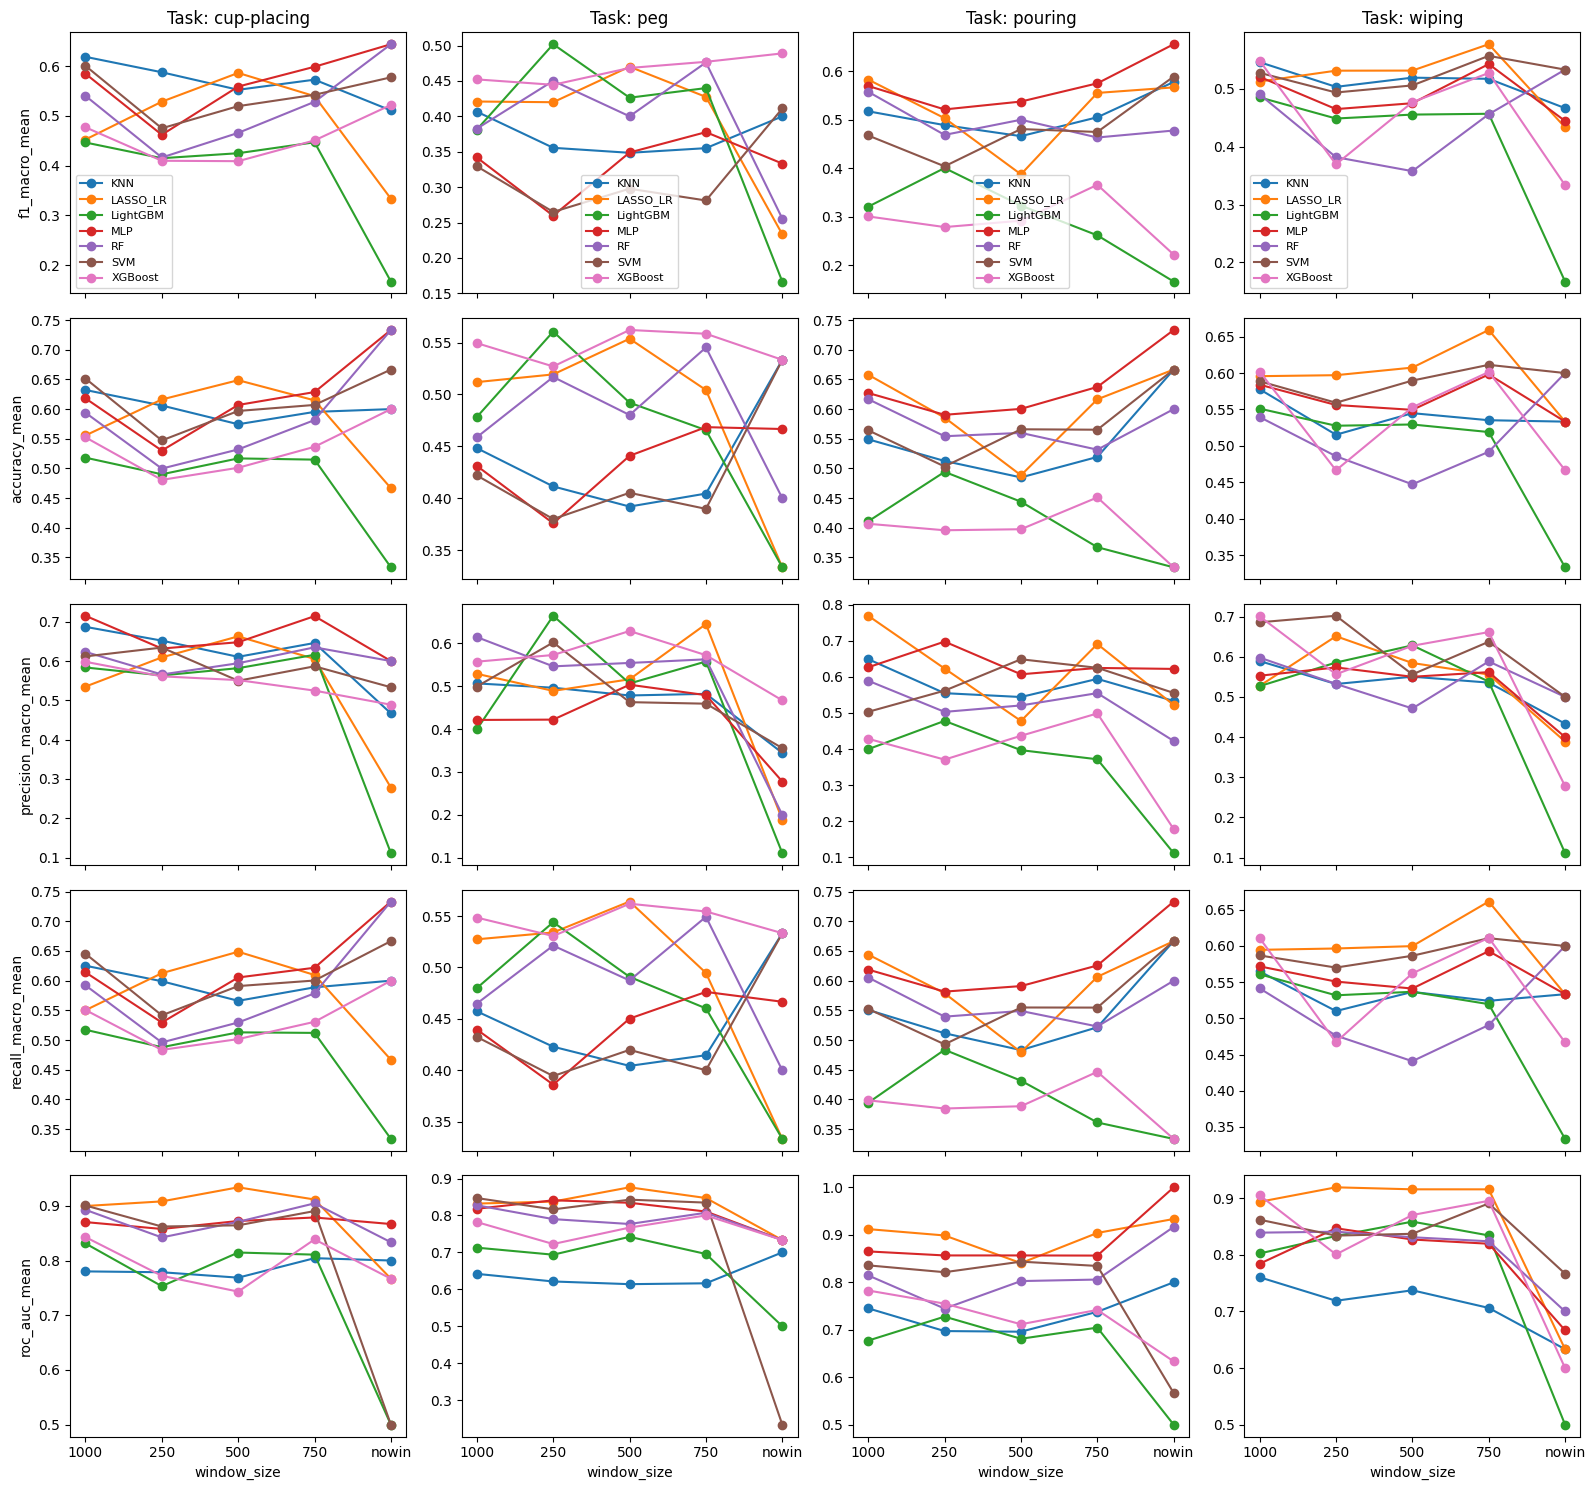

In [31]:
tasks = sorted(summary['task'].unique())
n_rows = len(metrics)      # 5 rows (one per metric)
n_cols = len(tasks)        # e.g. 4 tasks → 4 columns

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex='col'
)

# Make axes always 2D
if n_rows == 1 and n_cols == 1:
    axes = [[axes]]
elif n_rows == 1:
    axes = [axes]
elif n_cols == 1:
    axes = [[ax] for ax in axes]

for i, metric in enumerate(metrics):
    for j, task in enumerate(tasks):
        ax = axes[i][j]

        df_task = summary[summary['task'] == task]
        models = df_task['model_name'].unique()

        for model in models:
            df_tm = (
                df_task[df_task['model_name'] == model]
                .sort_values('window_size')
            )

            x = df_tm['window_size']
            y = df_tm[metric]

            ax.plot(x, y, marker='o', label=model)

        # Labels / titles
        if i == 0:
            ax.set_title(f"Task: {task}")
        if j == 0:
            ax.set_ylabel(metric)

        if i == n_rows - 1:
            ax.set_xlabel("window_size")

        # Legend only on the first row (one per column)
        if i == 0:
            ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [32]:
## Consider window of 1000 ms

In [33]:
# display per task
task_names = summary_by_window['task'].unique()
task_names

array(['cup-placing', 'peg', 'wiping', 'pouring'], dtype=object)

In [34]:

df_1000 = summary_by_window[summary_by_window['window_size'] == "750"]

for task_name in task_names:
    df_task = df_1000[df_1000["task"] == task_name]

    display(df_task.sort_values(by="f1_macro_mean"))

,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
13,cup-placing,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.447022,0.514884,0.615878,0.511994,0.810734
33,cup-placing,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.450854,0.536513,0.524782,0.530665,0.838603
23,cup-placing,RF,750,"{'max_depth': 10, 'n_estimators': 200}",0.528485,0.581542,0.634905,0.578642,0.904444
8,cup-placing,LASSO_LR,750,{'C': 10},0.539859,0.614722,0.605387,0.609590,0.911486
28,cup-placing,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.542676,0.607045,0.586645,0.600253,0.890397
3,cup-placing,KNN,750,"{'n_neighbors': 5, 'weights': 'uniform'}",0.573064,0.595324,0.646014,0.588772,0.804298
18,cup-placing,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.599079,0.628723,0.714311,0.621782,0.878638


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
63,peg,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.281206,0.389713,0.458966,0.400108,0.834773
38,peg,KNN,750,"{'n_neighbors': 3, 'weights': 'distance'}",0.355087,0.404460,0.481880,0.414714,0.616280
53,peg,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.377706,0.468458,0.478889,0.476240,0.810581
43,peg,LASSO_LR,750,{'C': 0.01},0.427445,0.504234,0.644206,0.494679,0.847172
48,peg,LightGBM,750,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.439923,0.465559,0.557144,0.460230,0.695664
58,peg,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.476089,0.545258,0.562222,0.549242,0.807284
68,peg,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.477014,0.558471,0.571893,0.554437,0.800135


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
128,wiping,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.456098,0.491964,0.588283,0.490764,0.823927
118,wiping,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.456946,0.519052,0.538145,0.519606,0.834286
108,wiping,KNN,750,"{'n_neighbors': 3, 'weights': 'uniform'}",0.517412,0.535262,0.535616,0.524240,0.706247
138,wiping,XGBoost,750,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.527520,0.601442,0.661354,0.611247,0.895400
123,wiping,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.542923,0.598090,0.561672,0.592880,0.819583
133,wiping,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.557110,0.611278,0.637262,0.610740,0.890795
113,wiping,LASSO_LR,750,{'C': 0.1},0.577287,0.659108,0.555685,0.661426,0.915665


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
83,pouring,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.261901,0.367325,0.371530,0.361047,0.704520
103,pouring,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.365976,0.451205,0.498760,0.446434,0.741771
93,pouring,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.463443,0.531675,0.555056,0.522847,0.805735
98,pouring,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.474821,0.565289,0.625290,0.554633,0.834393
73,pouring,KNN,750,"{'n_neighbors': 5, 'weights': 'distance'}",0.505083,0.519388,0.594578,0.521456,0.737813
78,pouring,LASSO_LR,750,{'C': 1},0.555215,0.616500,0.691177,0.606475,0.903910
88,pouring,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.574977,0.637347,0.624894,0.625614,0.856235


In [35]:
df_task

,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
93,pouring,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.463443,0.531675,0.555056,0.522847,0.805735
103,pouring,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.365976,0.451205,0.498760,0.446434,0.741771
98,pouring,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.474821,0.565289,0.625290,0.554633,0.834393
83,pouring,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.261901,0.367325,0.371530,0.361047,0.704520
88,pouring,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.574977,0.637347,0.624894,0.625614,0.856235
73,pouring,KNN,750,"{'n_neighbors': 5, 'weights': 'distance'}",0.505083,0.519388,0.594578,0.521456,0.737813
78,pouring,LASSO_LR,750,{'C': 1},0.555215,0.616500,0.691177,0.606475,0.903910


In [36]:
# 4) Exclude the "all tasks" row(s)
df_1000_no_all = df_1000[df_1000['task'] != 'all tasks'].copy()

# 5) Average metrics across tasks per model
avg_across_tasks = (
    df_1000_no_all
    .groupby('model_name', as_index=False)[metrics]
    .mean()
    .sort_values('f1_macro_mean', ascending=False)   # sort by best f1_macro
)

display(avg_across_tasks)


,model_name,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
1,LASSO_LR,0.524952,0.598641,0.624114,0.593043,0.894558
3,MLP,0.523671,0.583155,0.594942,0.579129,0.841259
0,KNN,0.487662,0.513609,0.564522,0.512296,0.716159
4,RF,0.481028,0.537610,0.585117,0.535374,0.835347
5,SVM,0.463953,0.543331,0.577041,0.541433,0.862590
6,XGBoost,0.455341,0.536908,0.564197,0.535696,0.818978
2,LightGBM,0.401448,0.466705,0.520674,0.463219,0.761301


In [37]:
best_models = ["LASSO_LR", "MLP", "KNN"]

In [38]:

df_1000 = summary_by_window[summary_by_window['window_size'] == "750"]
df_1000_best = df_1000[df_1000["model_name"].isin(best_models)]

for task_name in task_names:
    df_task = df_1000_best[df_1000_best["task"] == task_name]

    display(df_task.sort_values(by="f1_macro_mean"))

,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
8,cup-placing,LASSO_LR,750,{'C': 10},0.539859,0.614722,0.605387,0.609590,0.911486
3,cup-placing,KNN,750,"{'n_neighbors': 5, 'weights': 'uniform'}",0.573064,0.595324,0.646014,0.588772,0.804298
18,cup-placing,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.599079,0.628723,0.714311,0.621782,0.878638


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
38,peg,KNN,750,"{'n_neighbors': 3, 'weights': 'distance'}",0.355087,0.404460,0.481880,0.414714,0.616280
53,peg,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.377706,0.468458,0.478889,0.476240,0.810581
43,peg,LASSO_LR,750,{'C': 0.01},0.427445,0.504234,0.644206,0.494679,0.847172


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
108,wiping,KNN,750,"{'n_neighbors': 3, 'weights': 'uniform'}",0.517412,0.535262,0.535616,0.524240,0.706247
123,wiping,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.542923,0.598090,0.561672,0.592880,0.819583
113,wiping,LASSO_LR,750,{'C': 0.1},0.577287,0.659108,0.555685,0.661426,0.915665


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
73,pouring,KNN,750,"{'n_neighbors': 5, 'weights': 'distance'}",0.505083,0.519388,0.594578,0.521456,0.737813
78,pouring,LASSO_LR,750,{'C': 1},0.555215,0.616500,0.691177,0.606475,0.903910
88,pouring,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.574977,0.637347,0.624894,0.625614,0.856235


In [39]:

metrics = ['f1_macro_mean', 'accuracy_mean', 'precision_macro_mean', 'recall_macro_mean', 'roc_auc_mean']

# 1) Start from summary_by_window and exclude "all tasks"
df_no_all = summary_by_window[summary_by_window['task'] != 'all tasks'].copy()

# 2) Exclude the "no window" rows BEFORE converting to int
#    (cover a few possible spellings just in case)
no_win_labels = ['no_win', 'nowin', 'No_win', 'NO_WIN']

df_no_all = df_no_all[~df_no_all['window_size'].isin(no_win_labels)]

# 3) Safely convert window_size to numeric ints
df_no_all['window_size'] = pd.to_numeric(df_no_all['window_size'], errors='coerce')
df_no_all = df_no_all.dropna(subset=['window_size'])
df_no_all['window_size'] = df_no_all['window_size'].astype(int)

# 4) Average metrics across tasks for each (model_name, window_size)
avg_tasks = (
    df_no_all
    .groupby(['model_name', 'window_size'], as_index=False)[metrics]
    .mean()
)

# Optional: std across tasks for error bars (accuracy & f1_macro)
std_tasks = (
    df_no_all
    .groupby(['model_name', 'window_size'], as_index=False)[['accuracy_mean', 'f1_macro_mean']]
    .std()
    .rename(columns={'accuracy_mean': 'accuracy_std', 'f1_macro_mean': 'f1_macro_std'})
)

avg_tasks = avg_tasks.merge(std_tasks, on=['model_name', 'window_size'], how='left')



In [40]:
# Font parameters (tweak as you like)
TITLE_FONTSIZE  = 16
LABEL_FONTSIZE  = 14
TICK_FONTSIZE   = 12
LEGEND_FONTSIZE = 12


models = avg_tasks['model_name'].unique()
window_sizes = sorted(avg_tasks['window_size'].unique())

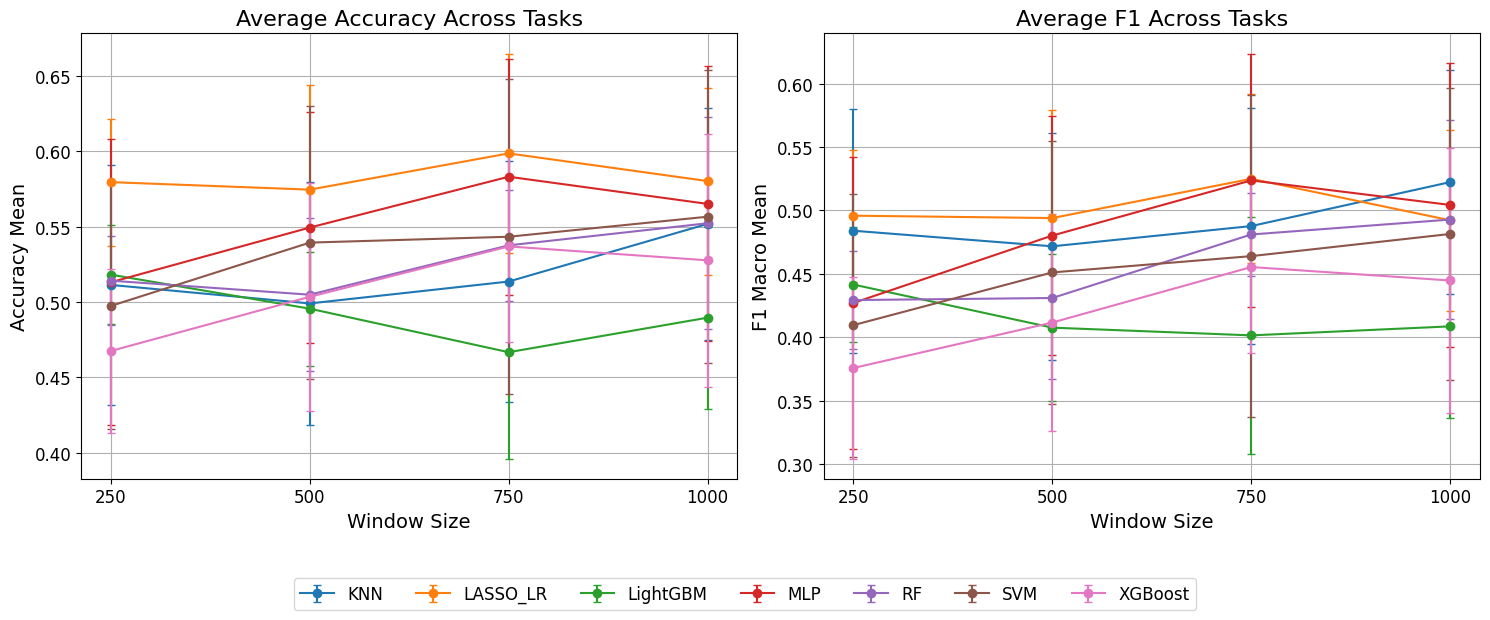

In [41]:


fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# --- Left: Accuracy ---
for model in models:
    df_m = avg_tasks[avg_tasks['model_name'] == model].sort_values('window_size')
    axes[0].errorbar(
        df_m['window_size'],
        df_m['accuracy_mean'],
        yerr=df_m['accuracy_std'],
        marker='o',
        capsize=3,
        label=model
    )

axes[0].set_title("Average Accuracy Across Tasks", fontsize=TITLE_FONTSIZE)
axes[0].set_xlabel("Window Size", fontsize=LABEL_FONTSIZE)
axes[0].set_ylabel("Accuracy Mean", fontsize=LABEL_FONTSIZE)

# --- Right: F1 Macro ---
for model in models:
    df_m = avg_tasks[avg_tasks['model_name'] == model].sort_values('window_size')
    axes[1].errorbar(
        df_m['window_size'],
        df_m['f1_macro_mean'],
        yerr=df_m['f1_macro_std'],
        marker='o',
        capsize=3,
        label=model
    )

axes[1].set_title("Average F1 Across Tasks", fontsize=TITLE_FONTSIZE)
axes[1].set_xlabel("Window Size", fontsize=LABEL_FONTSIZE)
axes[1].set_ylabel("F1 Macro Mean", fontsize=LABEL_FONTSIZE)

# Common stuff for both axes
for ax in axes:
    ax.set_xticks([250, 500, 750, 1000])
    ax.grid()
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)

# ---- Shared legend ----
# Grab handles & labels from one axis (they're the same across both)
handles, labels = axes[0].get_legend_handles_labels()

# Remove individual legends
for ax in axes:
    ax.legend().remove()

# Add one shared legend under the plots (or wherever you prefer)
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=len(models),
    fontsize=LEGEND_FONTSIZE,
    bbox_to_anchor=(0.5, 0.04)  # adjust vertical position if needed
)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
plt.show()



# Permutation - Importance Plots

Let’s start with permutation feature importance, because this is one of the simplest interpretability methods to explain. It’s a model interpretation technique that assigns an importance value for each feature. The importance is computed as how much the model performance would drop if we shuffle a feature. The more the performance drops (aka loss increases), the more important the feature was for correct predictions.

This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.




In [42]:
# folder where you saved perm_* files
SAVE_DIR = r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\ModelsFinal"

In [56]:


# ----------------- style params -----------------
TITLE_FONTSIZE  = 16
LABEL_FONTSIZE  = 14
TICK_FONTSIZE   = 11

N_COLS = 4
TOPK = 10
FIG_W, FIG_H = 15, 6

# ------------------------------------------------

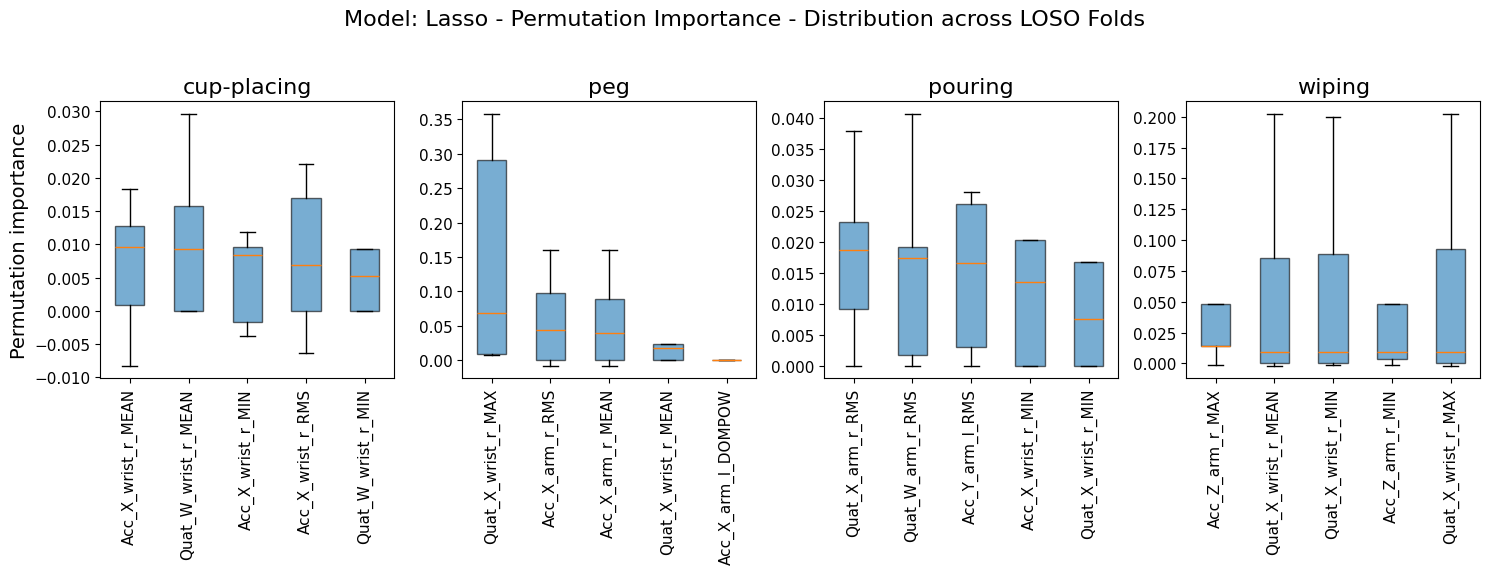

In [58]:


MODEL_NAME = "LASSO_LR"
name_for_title = 'Lasso'
TOPK = 5


# files: perm_{task}_{model}_test.csv
pattern = os.path.join(SAVE_DIR, f"perm_*_{MODEL_NAME}_test.csv")
files = sorted(glob.glob(pattern))
if len(files) == 0:
    raise FileNotFoundError(f"No files found with pattern: {pattern}")

df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# tasks order + empty last panel
tasks = [t for t in df_all["task"].unique() if t != "all_task"]
tasks = tasks[:4] + ["all_task"]

fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

for ax, task_name in zip(axes, tasks):
    if task_name == "all_task":
        ax.set_title("all_task", fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "empty", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    df_t = df_all[df_all["task"] == task_name].copy()

    # robust top-K: median across subjects
    feat_rank = (
        df_t.groupby(["subject", "feature"])["perm_importance_mean"].mean()
            .reset_index()
            .groupby("feature")["perm_importance_mean"]
            .median()
            .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    # build data list (one array per feature across subjects)
    data_lists = []
    for feat in top_feats:
        vals = df_t[df_t["feature"] == feat]["perm_importance_mean"].values
        data_lists.append(vals)

    bp = ax.boxplot(
        data_lists,
        showfliers=False,
        patch_artist=True
    )

    # light styling (matplotlib default color)
    for patch in bp["boxes"]:
        patch.set_alpha(0.6)
        patch.set_linewidth(1.0)
    for element in ["whiskers", "caps", "medians"]:
        for line in bp[element]:
            line.set_linewidth(1.0)

    ax.set_title(task_name, fontsize=TITLE_FONTSIZE)
    #ax.set_xlabel("Feature", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

    ax.set_xticks(np.arange(1, len(top_feats) + 1))
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)

axes[0].set_ylabel("Permutation importance", fontsize=LABEL_FONTSIZE)

plt.suptitle(f"Model: {name_for_title} - Permutation Importance - Distribution across LOSO Folds", fontsize=TITLE_FONTSIZE)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Shap Importance

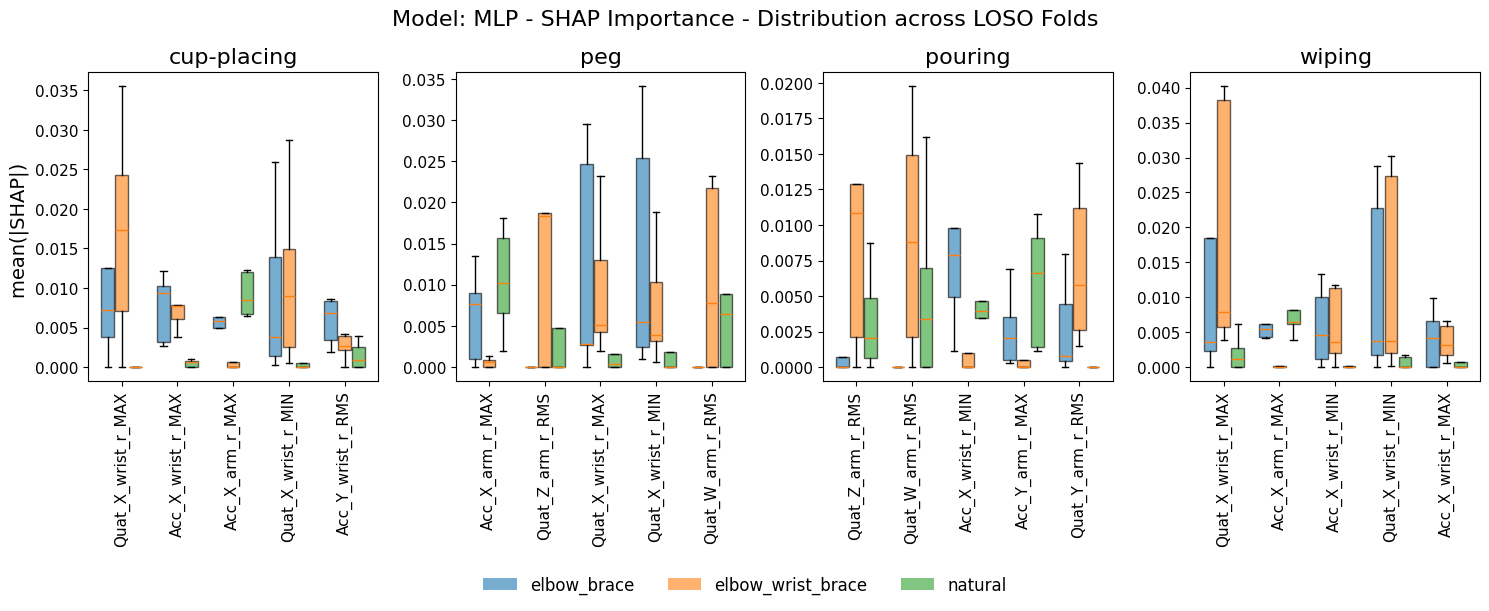

In [60]:
FIG_W, FIG_H = 15, 6

MODEL_NAME = "MLP"
name_for_title = "MLP"
TOPK = 5

# expected files: shap_{task}_{model}_test.csv
pattern = os.path.join(SAVE_DIR, f"shap_*_{MODEL_NAME}_test.csv")
files = sorted(glob.glob(pattern))
if len(files) == 0:
    raise FileNotFoundError(f"No files found with pattern: {pattern}")

df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

tasks = [t for t in df_all["task"].unique() if t != "all_task"]
tasks = tasks[:4] + ["all_task"]

cond_map = {0: "elbow_brace", 1: "elbow_wrist_brace", 2: "natural"}
df_all["condition"] = df_all["class"].map(cond_map)

# keep fixed order for conditions
cond_order = ["elbow_brace", "elbow_wrist_brace", "natural"]

# colors (matplotlib default cycle-ish)
cond_colors = {
    "elbow_brace": None,
    "elbow_wrist_brace": None,
    "natural": None,
}
# use default cycle automatically
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, c in enumerate(cond_order):
    cond_colors[c] = default_colors[i % len(default_colors)]

fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

for ax, task_name in zip(axes, tasks):
    if task_name == "all_task":
        ax.set_title("all_task", fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "empty", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    df_t = df_all[df_all["task"] == task_name].copy()

    # robust top-K: median across subjects of total SHAP across conditions
    feat_rank = (
        df_t.groupby(["subject", "feature"])["mean_abs_shap"].sum()
            .reset_index()
            .groupby("feature")["mean_abs_shap"]
            .median()
            .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    # --- build grouped boxplots: 3 boxes per feature ---
    n_feat = len(top_feats)
    n_cond = len(cond_order)

    base = np.arange(n_feat)  # feature centers at 0..n_feat-1
    group_width = 0.75        # total width occupied by the 3 boxes around each feature
    box_w = group_width / n_cond

    # positions for each condition within each feature group
    offsets = np.linspace(-group_width/2 + box_w/2, group_width/2 - box_w/2, n_cond)

    # collect data arrays per condition (list length n_feat)
    for ci, cond in enumerate(cond_order):
        data_lists = []
        for feat in top_feats:
            vals = df_t[(df_t["feature"] == feat) & (df_t["condition"] == cond)]["mean_abs_shap"].values
            data_lists.append(vals)

        pos = base + offsets[ci]

        bp = ax.boxplot(
            data_lists,
            positions=pos,
            widths=box_w * 0.9,
            patch_artist=True,
            showfliers=False,
            manage_ticks=False
        )

        # color styling
        for patch in bp["boxes"]:
            patch.set_facecolor(cond_colors[cond])
            patch.set_alpha(0.6)
            patch.set_linewidth(1.0)
        for element in ["whiskers", "caps", "medians"]:
            for line in bp[element]:
                line.set_linewidth(1.0)

    ax.set_title(task_name, fontsize=TITLE_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

    # set x ticks at feature centers
    ax.set_xticks(base)
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)

axes[0].set_ylabel("mean(|SHAP|) ", fontsize=LABEL_FONTSIZE)

# ---- shared legend at the bottom ----
legend_patches = [mpatches.Patch(facecolor=cond_colors[c], alpha=0.6, label=c) for c in cond_order]
fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=3,
    fontsize=LEGEND_FONTSIZE,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle(f"Model: {name_for_title} - SHAP Importance - Distribution across LOSO Folds", fontsize=TITLE_FONTSIZE)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


### Results after re-training (script LOSO_Importance_Train)

In [117]:
# If you saved per-task/model mean_std metrics files:
#   metrics_{task}_{model}_mean_std.csv
# This loader will print mean±std for each task and model.

def print_task_metrics_from_mean_std(save_dir, model_names=("LASSO_LR", "MLP")):
    for model in model_names:
        files = [f for f in os.listdir(save_dir) if f.startswith("metrics_") and f.endswith(f"_{model}_mean_std.csv")]
        if not files:
            print(f"\n[WARN] No mean/std metric files found for {model} in {save_dir}")
            continue

        print(f"\n==== {model} (mean ± std across subjects) ====")
        for fn in sorted(files):
            dfm = pd.read_csv(os.path.join(save_dir, fn))
            task = dfm["task_"].iloc[0] if "task_" in dfm.columns else dfm["task"].iloc[0] if "task" in dfm.columns else fn

            # find metric columns automatically (expects ..._mean and ..._std)
            mean_cols = [c for c in dfm.columns if c.endswith("_mean")]
            std_cols  = [c for c in dfm.columns if c.endswith("_std")]

            # print compact line
            parts = []
            for mc in sorted(mean_cols):
                base = mc[:-5]  # strip _mean
                sc = base + "_std"
                mean_val = float(dfm[mc].iloc[0])
                std_val  = float(dfm[sc].iloc[0]) if sc in dfm.columns else float("nan")
                parts.append(f"{base}={mean_val:.2f}±{std_val:.2f}")

            print(f"- {task}: " + ", ".join(parts))


# folder where you saved perm_* files
SAVE_DIR = r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\ModelsFinal"
print_task_metrics_from_mean_std(SAVE_DIR, model_names=("LASSO_LR", "MLP"))


==== LASSO_LR (mean ± std across subjects) ====
- cup-placing: accuracy=0.61±0.17, f1_macro=0.54±0.21, precision_macro=0.66±0.23, recall_macro=0.60±0.17, roc_auc=0.91±0.07
- peg: accuracy=0.54±0.13, f1_macro=0.47±0.16, precision_macro=0.57±0.14, recall_macro=0.55±0.15, roc_auc=0.89±0.09
- pouring: accuracy=0.65±0.12, f1_macro=0.59±0.13, precision_macro=0.74±0.13, recall_macro=0.64±0.11, roc_auc=0.92±0.03
- wiping: accuracy=0.67±0.09, f1_macro=0.60±0.12, precision_macro=0.63±0.19, recall_macro=0.67±0.09, roc_auc=0.93±0.08

==== MLP (mean ± std across subjects) ====
- cup-placing: accuracy=0.61±0.12, f1_macro=0.58±0.13, precision_macro=0.69±0.09, recall_macro=0.61±0.13, roc_auc=0.87±0.06
- peg: accuracy=0.42±0.04, f1_macro=0.33±0.05, precision_macro=0.58±0.11, recall_macro=0.43±0.05, roc_auc=0.81±0.06
- pouring: accuracy=0.60±0.09, f1_macro=0.54±0.11, precision_macro=0.59±0.15, recall_macro=0.59±0.09, roc_auc=0.84±0.05
- wiping: accuracy=0.61±0.13, f1_macro=0.56±0.17, precision_macro=0.

# Global Model results

In [47]:
from config import CONFIG

In [115]:
# Read summary file
out_root = Path(CONFIG["models_folder"]) / "Global_CV_Explainability_bestcfg" / "metrics"

# which eval_task columns to show (force consistent ordering)
task_cols_order = ["all_tasks", "cup-placing", "peg", "pouring", "wiping"]

# all metrics you saved in the metrics agg csv
metric_cols = ["accuracy", "f1_macro", "precision_macro", "recall_macro", "roc_auc"]

metric_name_map = {
    "accuracy": "Accuracy",
    "f1_macro": "F1 (macro)",
    "precision_macro": "Precision (macro)",
    "recall_macro": "Recall (macro)",
    "roc_auc": "ROC-AUC (macro)",
}

def fmt(mu, sd, nd=2):
    if pd.isna(mu) or pd.isna(sd):
        return "-"
    return f"{mu:.{nd}f} ± {sd:.{nd}f}"

def read_metrics_agg(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # if your aggregation flattened to e.g. accuracy_mean / accuracy_std, keep as is.
    # If someone saved as accuracy__mean, normalize.
    df.columns = [c.replace("__", "_") for c in df.columns]

    # find eval_task column robustly
    if "eval_task" in df.columns:
        eval_col = "eval_task"
    elif "eval_task_" in df.columns:
        eval_col = "eval_task_"
        df = df.rename(columns={eval_col: "eval_task"})
        eval_col = "eval_task"
    else:
        # last-resort: any col containing both eval and task
        cand = [c for c in df.columns if ("eval" in c.lower() and "task" in c.lower())]
        if not cand:
            raise ValueError(f"Couldn't find eval_task column in {path.name}. Columns={list(df.columns)}")
        df = df.rename(columns={cand[0]: "eval_task"})
        eval_col = "eval_task"

    return df

# ---------------- LOAD + BUILD ONE TABLE ----------------
rows = []
all_tasks_seen = set(task_cols_order)

for model in models:
    f = out_root / f"metrics_all_tasks_{model}_best_agg_per_task.csv"
    if not f.exists():
        raise FileNotFoundError(f"Missing metrics file: {f}")

    df = read_metrics_agg(f)

    # tasks present in file
    tasks_found = list(pd.unique(df["eval_task"]))
    # keep your preferred order, but only those present
    tasks = [t for t in task_cols_order if t in tasks_found]
    # append any extras at the end (stable)
    tasks += [t for t in sorted(tasks_found) if t not in tasks]
    all_tasks_seen.update(tasks)

    for mc in metric_cols:
        row = {"Model": model, "Metric": metric_name_map.get(mc, mc)}

        for t in tasks:
            sub = df[df["eval_task"] == t]
            if sub.empty:
                row[t] = "-"
                continue

            r = sub.iloc[0]
            mcol = f"{mc}_mean"
            scol = f"{mc}_std"

            if mcol not in df.columns:
                # sometimes columns could be like f1_macro_mean_mean (if double-aggregated by mistake)
                alt = [c for c in df.columns if c.startswith(f"{mc}_mean")]
                if alt:
                    mcol = alt[0]
                else:
                    row[t] = "-"
                    continue
            if scol not in df.columns:
                alt = [c for c in df.columns if c.startswith(f"{mc}_std")]
                scol = alt[0] if alt else None

            mu = float(r[mcol]) if mcol in r.index else np.nan
            sd = float(r[scol]) if (scol is not None and scol in r.index) else np.nan
            row[t] = fmt(mu, sd, nd=2)

        rows.append(row)

# final column order (Model/Metric + task columns)
final_tasks = [t for t in task_cols_order if t in all_tasks_seen] + [t for t in sorted(all_tasks_seen) if t not in task_cols_order]
table = pd.DataFrame(rows, columns=["Model", "Metric"] + final_tasks)

print(table)
print("\n\n--- LaTeX (Overleaf) ---\n")
print(table.to_latex(index=False, escape=False))


      Model             Metric    all_tasks  cup-placing          peg  \
0  LASSO_LR           Accuracy  0.97 ± 0.02  0.98 ± 0.03  0.97 ± 0.04   
1  LASSO_LR         F1 (macro)  0.97 ± 0.02  0.98 ± 0.03  0.97 ± 0.04   
2  LASSO_LR  Precision (macro)  0.97 ± 0.02  0.98 ± 0.03  0.97 ± 0.03   
3  LASSO_LR     Recall (macro)  0.97 ± 0.02  0.98 ± 0.03  0.97 ± 0.04   
4  LASSO_LR    ROC-AUC (macro)  1.00 ± 0.01  1.00 ± 0.00  0.99 ± 0.02   
5       MLP           Accuracy  0.97 ± 0.03  0.98 ± 0.02  0.96 ± 0.05   
6       MLP         F1 (macro)  0.97 ± 0.03  0.98 ± 0.01  0.96 ± 0.05   
7       MLP  Precision (macro)  0.97 ± 0.03  0.98 ± 0.01  0.96 ± 0.05   
8       MLP     Recall (macro)  0.97 ± 0.03  0.98 ± 0.01  0.96 ± 0.05   
9       MLP    ROC-AUC (macro)  0.99 ± 0.01  1.00 ± 0.00  0.99 ± 0.02   

       pouring       wiping  
0  0.97 ± 0.02  0.97 ± 0.03  
1  0.97 ± 0.02  0.97 ± 0.03  
2  0.97 ± 0.02  0.97 ± 0.03  
3  0.97 ± 0.02  0.97 ± 0.03  
4  1.00 ± 0.00  1.00 ± 0.00  
5  0.96 ± 0.04  

## SHAP Importance

In [92]:
# ----------------- HELPERS -----------------
def pick_group_col(df):
    if "fold_idx" in df.columns: return "fold_idx"
    if "subject" in df.columns:  return "subject"
    raise ValueError("Need either 'fold_idx' or 'subject' in the PERM file.")

def pick_eval_task_col(df):
    for c in df.columns:
        if c.lower() in ["eval_task", "evaltask", "task_eval", "eval_task_name", "evaltaskname"]:
            return c
    for c in df.columns:
        if "eval" in c.lower() and "task" in c.lower():
            return c
    raise ValueError("Couldn't find eval-task column in *_evalTask.csv.")

In [98]:
# ----------------- CONFIG -----------------
FIG_W, FIG_H = 15, 6
TITLE_FONTSIZE  = 14
LABEL_FONTSIZE  = 12
TICK_FONTSIZE   = 10
LEGEND_FONTSIZE = 11

In [97]:
from pathlib import Path
SHAP_DIR = Path(r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\ModelsFinalGlobal\Global_CV_Explainability_bestcfg\shap")

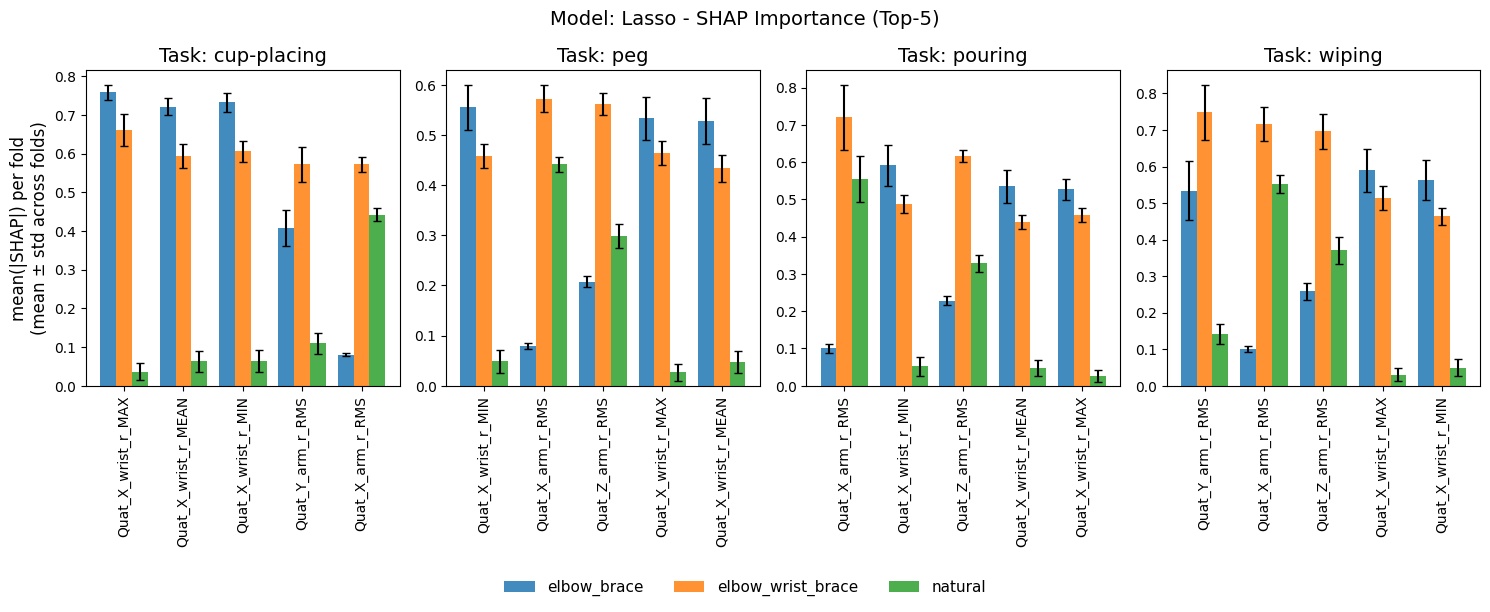

In [102]:




MODEL_NAME_FILE = "LASSO_LR"      # filenames use this
name_for_title  = "Lasso"
TOPK = 5
N_COLS = 4

# folder containing:
#   shap_all_tasks_{MODEL}_best_per_fold_evalTask.csv
# -------------------------------------------------------------
# SHAP_DIR = r"...\ModelsFinal\Global_CV_Explainability_bestcfg\shap"
# -------------------------------------------------------------

preferred_tasks = ["cup-placing", "peg", "pouring", "wiping"]

# class/condition mapping
cond_map = {0: "elbow_brace", 1: "elbow_wrist_brace", 2: "natural"}
cond_order = ["elbow_brace", "elbow_wrist_brace", "natural"]


# ----------------- HELPERS -----------------
def pick_group_col(df):
    if "fold_idx" in df.columns: return "fold_idx"
    if "subject" in df.columns:  return "subject"
    raise ValueError("Need either 'fold_idx' or 'subject' in the SHAP file.")

def pick_eval_task_col(df):
    for c in df.columns:
        if c.lower() in ["eval_task", "evaltask", "task_eval", "eval_task_name", "evaltaskname"]:
            return c
    for c in df.columns:
        if "eval" in c.lower() and "task" in c.lower():
            return c
    raise ValueError("Couldn't find eval-task column in *_evalTask.csv.")


# ----------------- LOAD FILE -----------------
f_eval = os.path.join(SHAP_DIR, f"shap_all_tasks_{MODEL_NAME_FILE}_best_per_fold_evalTask.csv")
if not os.path.exists(f_eval):
    raise FileNotFoundError(f"Missing:\n  {f_eval}")

df_eval = pd.read_csv(f_eval)

group_col     = pick_group_col(df_eval)
eval_task_col = pick_eval_task_col(df_eval)

# add condition labels (if classes are 0/1/2)
df_eval["condition"] = df_eval["class"].map(cond_map)

# tasks for first 4 columns + all_tasks
tasks_found = list(pd.unique(df_eval[eval_task_col]))
tasks_first4 = [t for t in preferred_tasks if t in tasks_found]
if len(tasks_first4) < 4:
    rest = [t for t in sorted(tasks_found) if t not in tasks_first4 and t != "all_tasks"]
    tasks_first4 = (tasks_first4 + rest)[:4]
tasks = tasks_first4 + ["all_tasks"]

# classes present (keep stable order if possible)
classes_present = sorted(df_eval["class"].unique())
# prefer [0,1,2] if available
classes = [c for c in [0, 1, 2] if c in classes_present] + [c for c in classes_present if c not in [0, 1, 2]]
class_names = [cond_map.get(c, f"class_{c}") for c in classes]

# colors from matplotlib default cycle
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
class_colors = {c: default_colors[i % len(default_colors)] for i, c in enumerate(classes)}


# ----------------- PLOT (mean ± std across folds) -----------------
fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

legend_handles = []

for ax, task_name in zip(axes, tasks):

    df_t = df_eval[df_eval[eval_task_col] == task_name].copy()
    title = "All tasks" if task_name == "all_tasks" else f"Task: {task_name}"

    if df_t.empty:
        ax.set_title(title, fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "missing", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    # collapse duplicates if any: per-(fold,feature,class)
    df_fc = (
        df_t.groupby([group_col, "feature", "class"], as_index=False)["mean_abs_shap"]
            .mean()
    )

    # robust Top-K features: for each fold+feature, sum over classes; then median over folds
    df_fold_feat = (
        df_fc.groupby([group_col, "feature"], as_index=False)["mean_abs_shap"]
            .sum()
    )
    feat_rank = (
        df_fold_feat.groupby("feature")["mean_abs_shap"]
                   .median()
                   .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    # mean±std across folds for each (feature,class)
    df_top = df_fc[df_fc["feature"].isin(top_feats)].copy()

    df_ms = (
        df_top.groupby(["feature", "class"])["mean_abs_shap"]
              .agg(["mean", "std"])
              .reset_index()
              .rename(columns={"mean": "shap_mean", "std": "shap_std"})
    )

    # enforce plotting order
    df_ms["feature"] = pd.Categorical(df_ms["feature"], categories=top_feats, ordered=True)
    df_ms["class"]   = pd.Categorical(df_ms["class"], categories=classes, ordered=True)
    df_ms = df_ms.sort_values(["feature", "class"])

    x = np.arange(len(top_feats))
    C = len(classes)
    width = 0.8 / C

    for i, c in enumerate(classes):
        sub = df_ms[df_ms["class"] == c].set_index("feature").reindex(top_feats)
        means = sub["shap_mean"].to_numpy()
        stds  = sub["shap_std"].fillna(0).to_numpy()

        bars = ax.bar(
            x + (i - (C - 1) / 2) * width,
            means,
            width=width,
            yerr=stds,
            capsize=3,
            label=class_names[i],
            color=class_colors[c],
            alpha=0.85
        )

        # capture legend once
        if task_name == tasks[0]:
            legend_handles.append(mpatches.Patch(facecolor=class_colors[c], label=class_names[i], alpha=0.85))

    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    ax.set_xticks(x)
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

axes[0].set_ylabel("mean(|SHAP|) per fold\n(mean ± std across folds)", fontsize=LABEL_FONTSIZE)

# shared legend bottom
fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=len(classes),
    fontsize=LEGEND_FONTSIZE,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle(f"Model: {name_for_title} - SHAP Importance (Top-{TOPK})", fontsize=TITLE_FONTSIZE)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


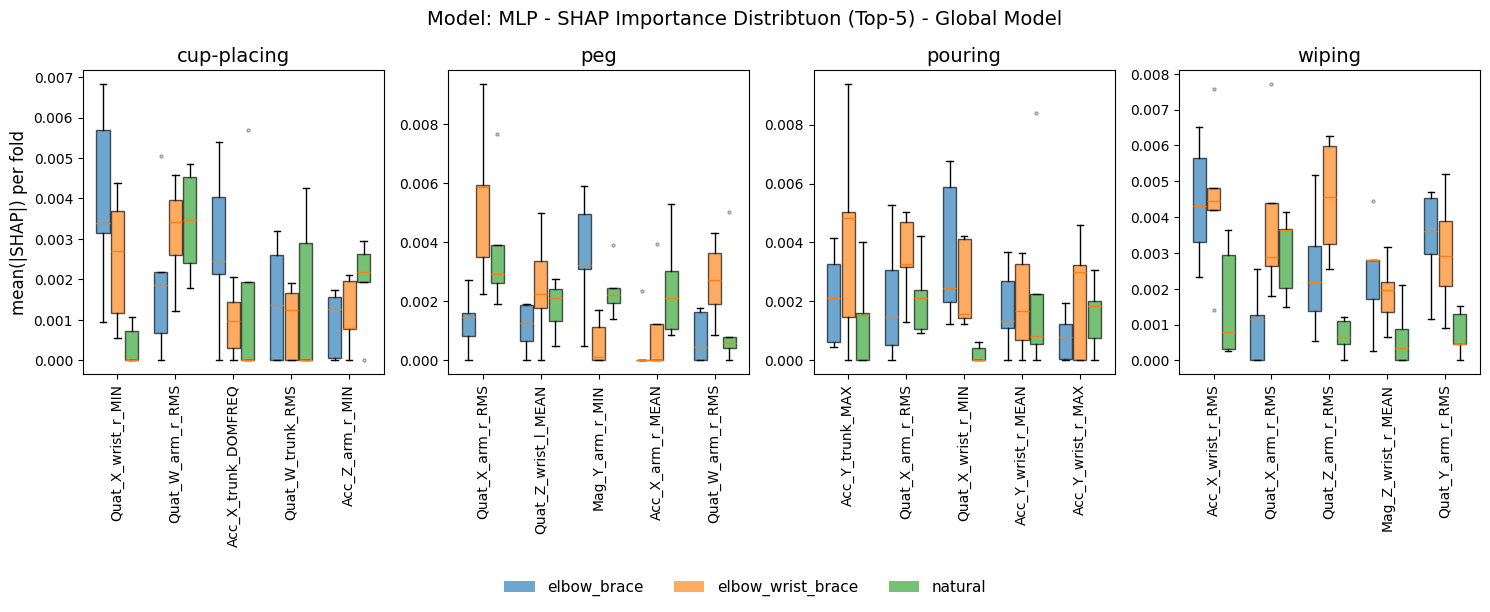

In [113]:
# ----------------- LOAD FILE -----------------


MODEL_NAME_FILE = "MLP"      # filenames use this
name_for_title  = "MLP"
TOPK = 5
N_COLS = 4              # if we want to exclude al_tasks, else 5

f_eval = os.path.join(SHAP_DIR, f"shap_all_tasks_{MODEL_NAME_FILE}_best_per_fold_evalTask.csv")
if not os.path.exists(f_eval):
    raise FileNotFoundError(f"Missing:\n  {f_eval}")

df_eval = pd.read_csv(f_eval)

group_col     = pick_group_col(df_eval)
eval_task_col = pick_eval_task_col(df_eval)

df_eval["condition"] = df_eval["class"].map(cond_map)

# tasks for first 4 columns + all_tasks
tasks_found = list(pd.unique(df_eval[eval_task_col]))
tasks_first4 = [t for t in preferred_tasks if t in tasks_found]
if len(tasks_first4) < 4:
    rest = [t for t in sorted(tasks_found) if t not in tasks_first4 and t != "all_tasks"]
    tasks_first4 = (tasks_first4 + rest)[:4]
tasks = tasks_first4 + ["all_tasks"]

# classes present (keep stable order if possible)
classes_present = sorted(df_eval["class"].unique())
classes = [c for c in [0, 1, 2] if c in classes_present] + [c for c in classes_present if c not in [0, 1, 2]]
class_names = [cond_map.get(c, f"class_{c}") for c in classes]

# colors (matplotlib default cycle)
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
class_colors = {c: default_colors[i % len(default_colors)] for i, c in enumerate(classes)}

# ----------------- PLOT (BOXPLOTS) -----------------

fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

for ax, task_name in zip(axes, tasks):

    df_t = df_eval[df_eval[eval_task_col] == task_name].copy()
    title = "All tasks" if task_name == "all_tasks" else f"{task_name}"

    if df_t.empty:
        ax.set_title(title, fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "missing", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    # collapse duplicates: per-(fold,feature,class)
    df_fc = (
        df_t.groupby([group_col, "feature", "class"], as_index=False)["mean_abs_shap"]
            .mean()
    )

    # robust Top-K: per-(fold,feature) sum across classes, then median across folds
    df_fold_feat = (
        df_fc.groupby([group_col, "feature"], as_index=False)["mean_abs_shap"]
            .sum()
    )
    feat_rank = (
        df_fold_feat.groupby("feature")["mean_abs_shap"]
                    .median()
                    .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    # grouped boxplots: 1 group per feature, 1 box per class
    n_feat = len(top_feats)
    C = len(classes)

    base = np.arange(n_feat)
    group_width = 0.75
    box_w = group_width / C
    offsets = np.linspace(-group_width/2 + box_w/2, group_width/2 - box_w/2, C)

    for i, c in enumerate(classes):
        data_lists = []
        for feat in top_feats:
            vals = df_fc[(df_fc["feature"] == feat) & (df_fc["class"] == c)]["mean_abs_shap"].values
            data_lists.append(vals)

        pos = base + offsets[i]

        bp = ax.boxplot(
            data_lists,
            positions=pos,
            widths=box_w * 0.9,
            patch_artist=True,
            showfliers=True,          # set False if too cluttered
            manage_ticks=False,
            flierprops=dict(marker='o', markersize=2, alpha=0.4),
        )

        # style
        for patch in bp["boxes"]:
            patch.set_facecolor(class_colors[c])
            patch.set_alpha(0.65)
            patch.set_linewidth(1.0)
        for element in ["whiskers", "caps", "medians"]:
            for line in bp[element]:
                line.set_linewidth(1.0)

    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    ax.set_xticks(base)
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

axes[0].set_ylabel("mean(|SHAP|) per fold", fontsize=LABEL_FONTSIZE)

# shared legend bottom
legend_patches = [
    mpatches.Patch(facecolor=class_colors[c], alpha=0.65, label=class_names[i])
    for i, c in enumerate(classes)
]
fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=len(classes),
    fontsize=LEGEND_FONTSIZE,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle(f"Model: {name_for_title} - SHAP Importance Distribtuon (Top-{TOPK}) - Global Model", fontsize=TITLE_FONTSIZE)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()

## Perm Importance

In [90]:
PERM_DIR = Path(r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\ModelsFinalGlobal\Global_CV_Explainability_bestcfg\perm")

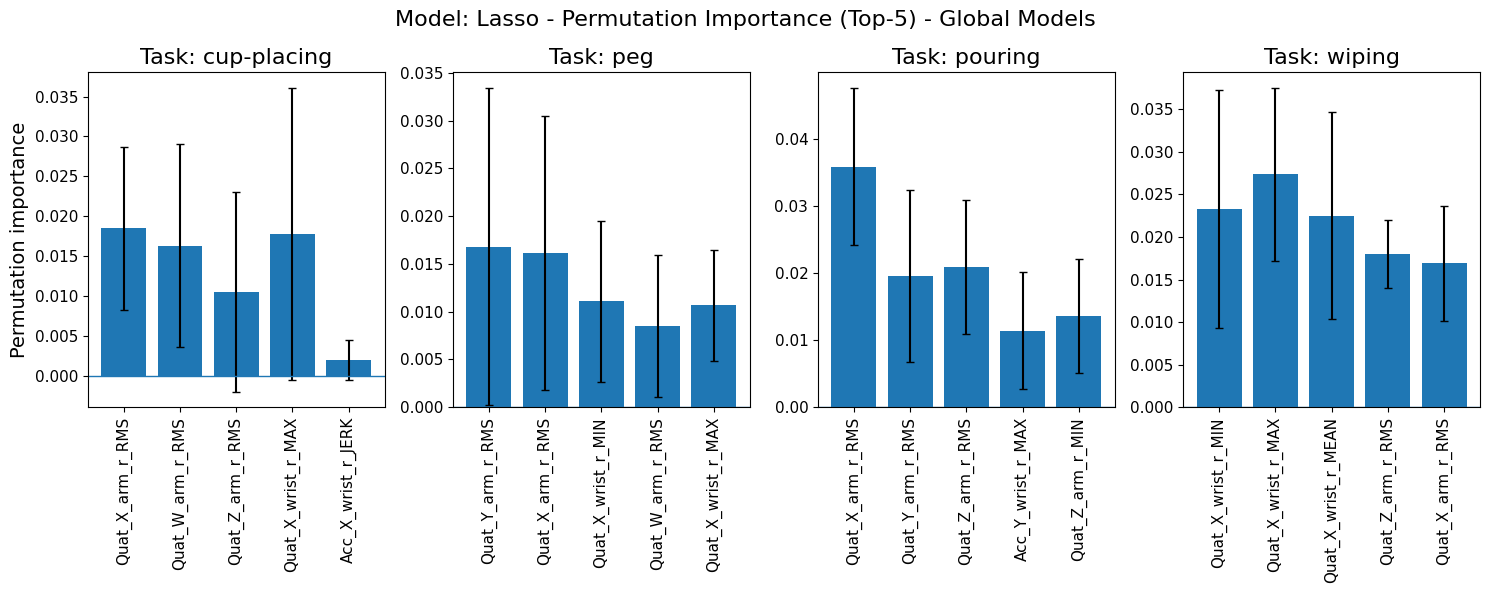

In [96]:
MODEL_NAME_FILE = "LASSO_LR"
name_for_title = "Lasso"

# ----------------- LOAD FILE -----------------
f_eval = os.path.join(PERM_DIR, f"perm_all_tasks_{MODEL_NAME_FILE}_best_per_fold_evalTask.csv")
if not os.path.exists(f_eval):
    raise FileNotFoundError(f"Missing:\n  {f_eval}")

df_eval = pd.read_csv(f_eval)

group_col    = pick_group_col(df_eval)
eval_task_col = pick_eval_task_col(df_eval)

# first 4 columns = tasks, last = all_tasks
tasks_found = list(pd.unique(df_eval[eval_task_col]))
tasks_first4 = [t for t in preferred_tasks if t in tasks_found]
if len(tasks_first4) < 4:
    rest = [t for t in sorted(tasks_found) if t not in tasks_first4 and t != "all_tasks"]
    tasks_first4 = (tasks_first4 + rest)[:4]
tasks = tasks_first4 + ["all_tasks"]


# ----------------- PLOT (mean ± std across folds) -----------------
fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

for ax, task_name in zip(axes, tasks):

    df_t = df_eval[df_eval[eval_task_col] == task_name].copy()
    title = "all_tasks (global model)" if task_name == "all_tasks" else f"Task: {task_name}"

    if df_t.empty:
        ax.set_title(title, fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "missing", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    # per-(fold,feature) value (in case of duplicates, average them)
    df_ff = (
        df_t.groupby([group_col, "feature"], as_index=False)["perm_importance_mean"]
            .mean()
    )

    # Robust Top-K: median across folds
    feat_rank = (
        df_ff.groupby("feature")["perm_importance_mean"]
             .median()
             .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    df_top = df_ff[df_ff["feature"].isin(top_feats)].copy()

    # mean ± std across folds for each feature
    df_ms = (
        df_top.groupby("feature")["perm_importance_mean"]
              .agg(["mean", "std"])
              .reindex(top_feats)   # keep the TopK order
              .reset_index()
              .rename(columns={"mean": "perm_mean", "std": "perm_std"})
    )

    x = np.arange(len(top_feats))
    means = df_ms["perm_mean"].to_numpy()
    stds  = df_ms["perm_std"].fillna(0).to_numpy()

    ax.bar(x, means, yerr=stds, capsize=3)
    ax.axhline(0.0, linewidth=1.0)

    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    ax.set_xticks(x)
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

axes[0].set_ylabel("Permutation importance", fontsize=LABEL_FONTSIZE)

plt.suptitle(f"Model: {name_for_title} - Permutation Importance (Top-{TOPK}) - Global Models", fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()

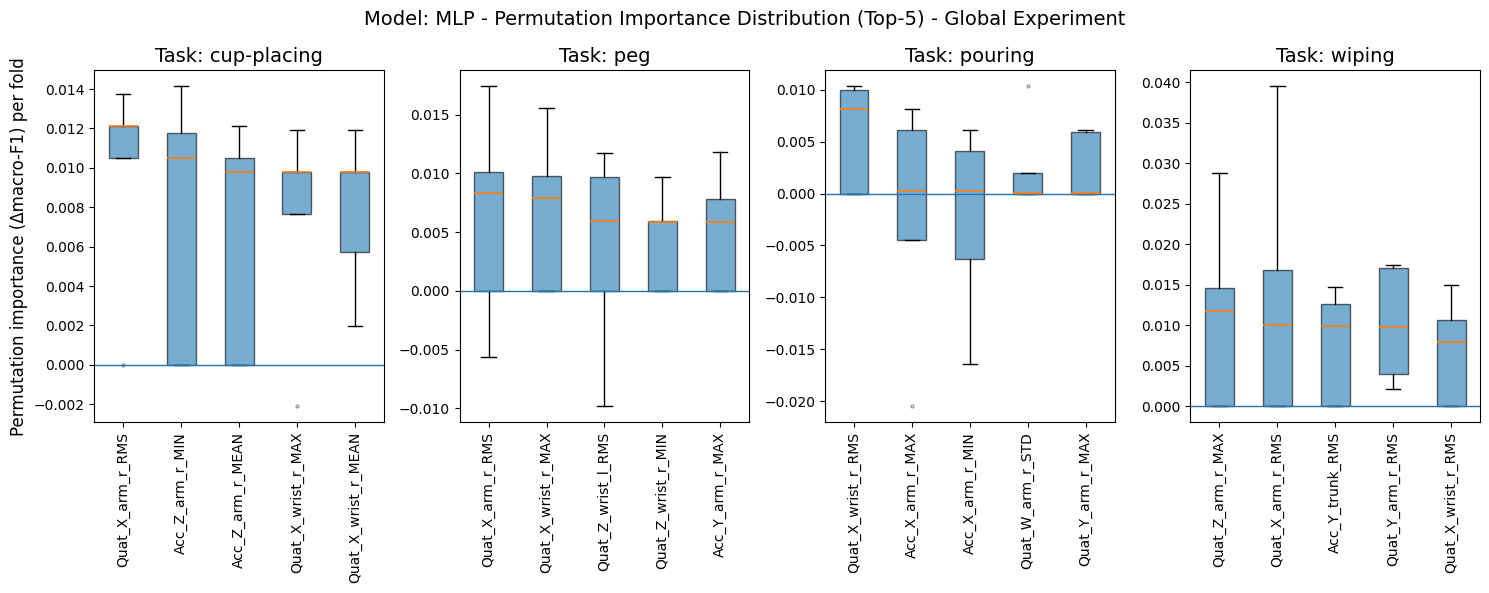

In [111]:
# ----------------- LOAD FILE -----------------


MODEL_NAME_FILE = "MLP"      # filenames use this
name_for_title  = "MLP"
TOPK = 5
N_COLS = 4              # if we want to exclude al_tasks, else 5
f_eval = os.path.join(PERM_DIR, f"perm_all_tasks_{MODEL_NAME_FILE}_best_per_fold_evalTask.csv")
if not os.path.exists(f_eval):
    raise FileNotFoundError(f"Missing:\n  {f_eval}")

df_eval = pd.read_csv(f_eval)

group_col     = pick_group_col(df_eval)
eval_task_col = pick_eval_task_col(df_eval)

# tasks for first 4 columns + all_tasks
tasks_found = list(pd.unique(df_eval[eval_task_col]))
tasks_first4 = [t for t in preferred_tasks if t in tasks_found]
if len(tasks_first4) < 4:
    rest = [t for t in sorted(tasks_found) if t not in tasks_first4 and t != "all_tasks"]
    tasks_first4 = (tasks_first4 + rest)[:4]
tasks = tasks_first4 + ["all_tasks"]

# ----------------- PLOT (BOXPLOTS) -----------------


fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

for ax, task_name in zip(axes, tasks):

    df_t = df_eval[df_eval[eval_task_col] == task_name].copy()
    title = "All tasks" if task_name == "all_tasks" else f"Task: {task_name}"

    if df_t.empty:
        ax.set_title(title, fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "missing", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    # robust Top-K: for each fold+feature take mean (over repeats), then median across folds
    df_ff = (
        df_t.groupby([group_col, "feature"], as_index=False)["perm_importance_mean"]
            .mean()
    )
    feat_rank = (
        df_ff.groupby("feature")["perm_importance_mean"]
             .median()
             .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    # build per-feature arrays: values across folds
    data_lists = []
    for feat in top_feats:
        vals = df_ff[df_ff["feature"] == feat]["perm_importance_mean"].values
        data_lists.append(vals)

    bp = ax.boxplot(
        data_lists,
        patch_artist=True,
        showfliers=True,               # set False if too cluttered
        flierprops=dict(marker='o', markersize=2, alpha=0.4),
        medianprops=dict(linewidth=1.2),
    )

    # subtle styling
    for patch in bp["boxes"]:
        patch.set_alpha(0.6)
        patch.set_linewidth(1.0)
    for element in ["whiskers", "caps"]:
        for line in bp[element]:
            line.set_linewidth(1.0)

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    ax.set_xticks(np.arange(1, len(top_feats) + 1))
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

axes[0].set_ylabel("Permutation importance (Δmacro-F1) per fold", fontsize=LABEL_FONTSIZE)

plt.suptitle(f"Model: {name_for_title} - Permutation Importance Distribution (Top-{TOPK}) - Global Experiment", fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()